In [2]:
import sys
import os
from pathlib import Path

# Add the project root to Python path
cwd = os.getcwd()
print(cwd)
project_root = Path(cwd).parent  # Go up to project root
# Sys.path is a list of dirs that python searches through for importing modules and files
# I'm adding the root to the path so the file can import things as if it were running from root
# This way I can keep my tests organized, but it still acts like I'm running from root
sys.path.insert(0, str(project_root))

from jsbgym.control_system.rp_flight_evals import *
from jsbgym.aircraft import *
import jsbgym.properties as prp
from jsbgym.control_system.rp_flight_pid import *

d:\1DrvTK\OneDrive\GitHub\ADMBenchmark\control_system_evaluations


In [3]:
class FlightPathFixedSubsystem:
    def __init__(self, elevator_cmd, throttle_cmd=None) -> None:
        self.num_steps = 0    
        self.elevator_cmd = elevator_cmd
        self.throttle_cmd = throttle_cmd
    def action(self, sim: SimulationInterface, des_pitch):
        actions = {
            prp.elevator_cmd: self.elevator_cmd
        }

        if self.throttle_cmd != None:
            actions[prp.throttle_cmd] = self.throttle_cmd      

        self.num_steps += 1

        return actions

In [4]:
def run_cmds(control_evaluator: RPFlightControlEval, set_elev, flight_path, set_throttle, des_airspeed):
    control_subsystem = RPPIDControlSubsystem(pitch_subsystem=FlightPathFixedSubsystem(set_elev, set_throttle))

    control_evaluator.run_specific_eval(flight_path, flight_path, 0, 0, control_subsystem, render_mode="", aircraft=c172x, start_airspeed=des_airspeed)
    avg_flight_path = sum(control_evaluator.trjs_flight_path_error[-1]) / len(control_evaluator.trjs_flight_path_error[-1])
    print(f"Elev cmd: {set_elev}, Avg flight path: {avg_flight_path}")

    return avg_flight_path

In [9]:
control_evaluator = RPFlightControlEval(c172x)
flight_path = 1
des_airspeed = 92
des_error = 0.05
set_throttle = 1
max_guesses = 10

upper_bound_elv_cmd = 0.5
lower_bound_elv_cmd = -0.5
upper_bound_flight_path = run_cmds(control_evaluator, lower_bound_elv_cmd, flight_path, set_throttle, des_airspeed) # degrees
lower_bound_flight_path = run_cmds(control_evaluator, upper_bound_elv_cmd, flight_path, set_throttle, des_airspeed)
set_cmd_flight_path = 1000 # arbitrary
guesses = 0

while abs(set_cmd_flight_path) > des_error and guesses < max_guesses:
    set_elev_cmd = (upper_bound_elv_cmd + lower_bound_elv_cmd) / 2
    set_cmd_flight_path = run_cmds(control_evaluator, set_elev_cmd, flight_path, set_throttle, des_airspeed)
    if set_cmd_flight_path > flight_path:
        lower_bound_elv_cmd = set_elev_cmd
    else:
        upper_bound_elv_cmd = set_elev_cmd
    
    guesses += 1


155.2776
Running simulation for 525.0 steps
Engines set to running!
0.07807302122394609
Elev cmd: -0.5, Avg flight path: 2.5931102474401437
155.2776
Running simulation for 525.0 steps
Engines set to running!
0.02220041209296468
Elev cmd: 0.5, Avg flight path: -13.76486942211687
155.2776
Running simulation for 525.0 steps
Engines set to running!
0.047620931676976126
Elev cmd: 0.0, Avg flight path: 4.087835487800909
155.2776
Running simulation for 525.0 steps
Engines set to running!
0.03742457917110706
Elev cmd: 0.25, Avg flight path: -9.78221050356974
155.2776
Running simulation for 525.0 steps
Engines set to running!
0.04477680097644867
Elev cmd: 0.125, Avg flight path: 0.7785217073574875
155.2776
Running simulation for 525.0 steps
Engines set to running!
0.047620931676976126
Elev cmd: 0.0625, Avg flight path: 4.083129645532602
155.2776
Running simulation for 525.0 steps
Engines set to running!
0.046439579066117447
Elev cmd: 0.09375, Avg flight path: 2.8560986214151027
155.2776
Running

155.2776
Running simulation for 525.0 steps
Engines set to running!
0.04611403873736178
Avg flight path: 2.5555654679864954


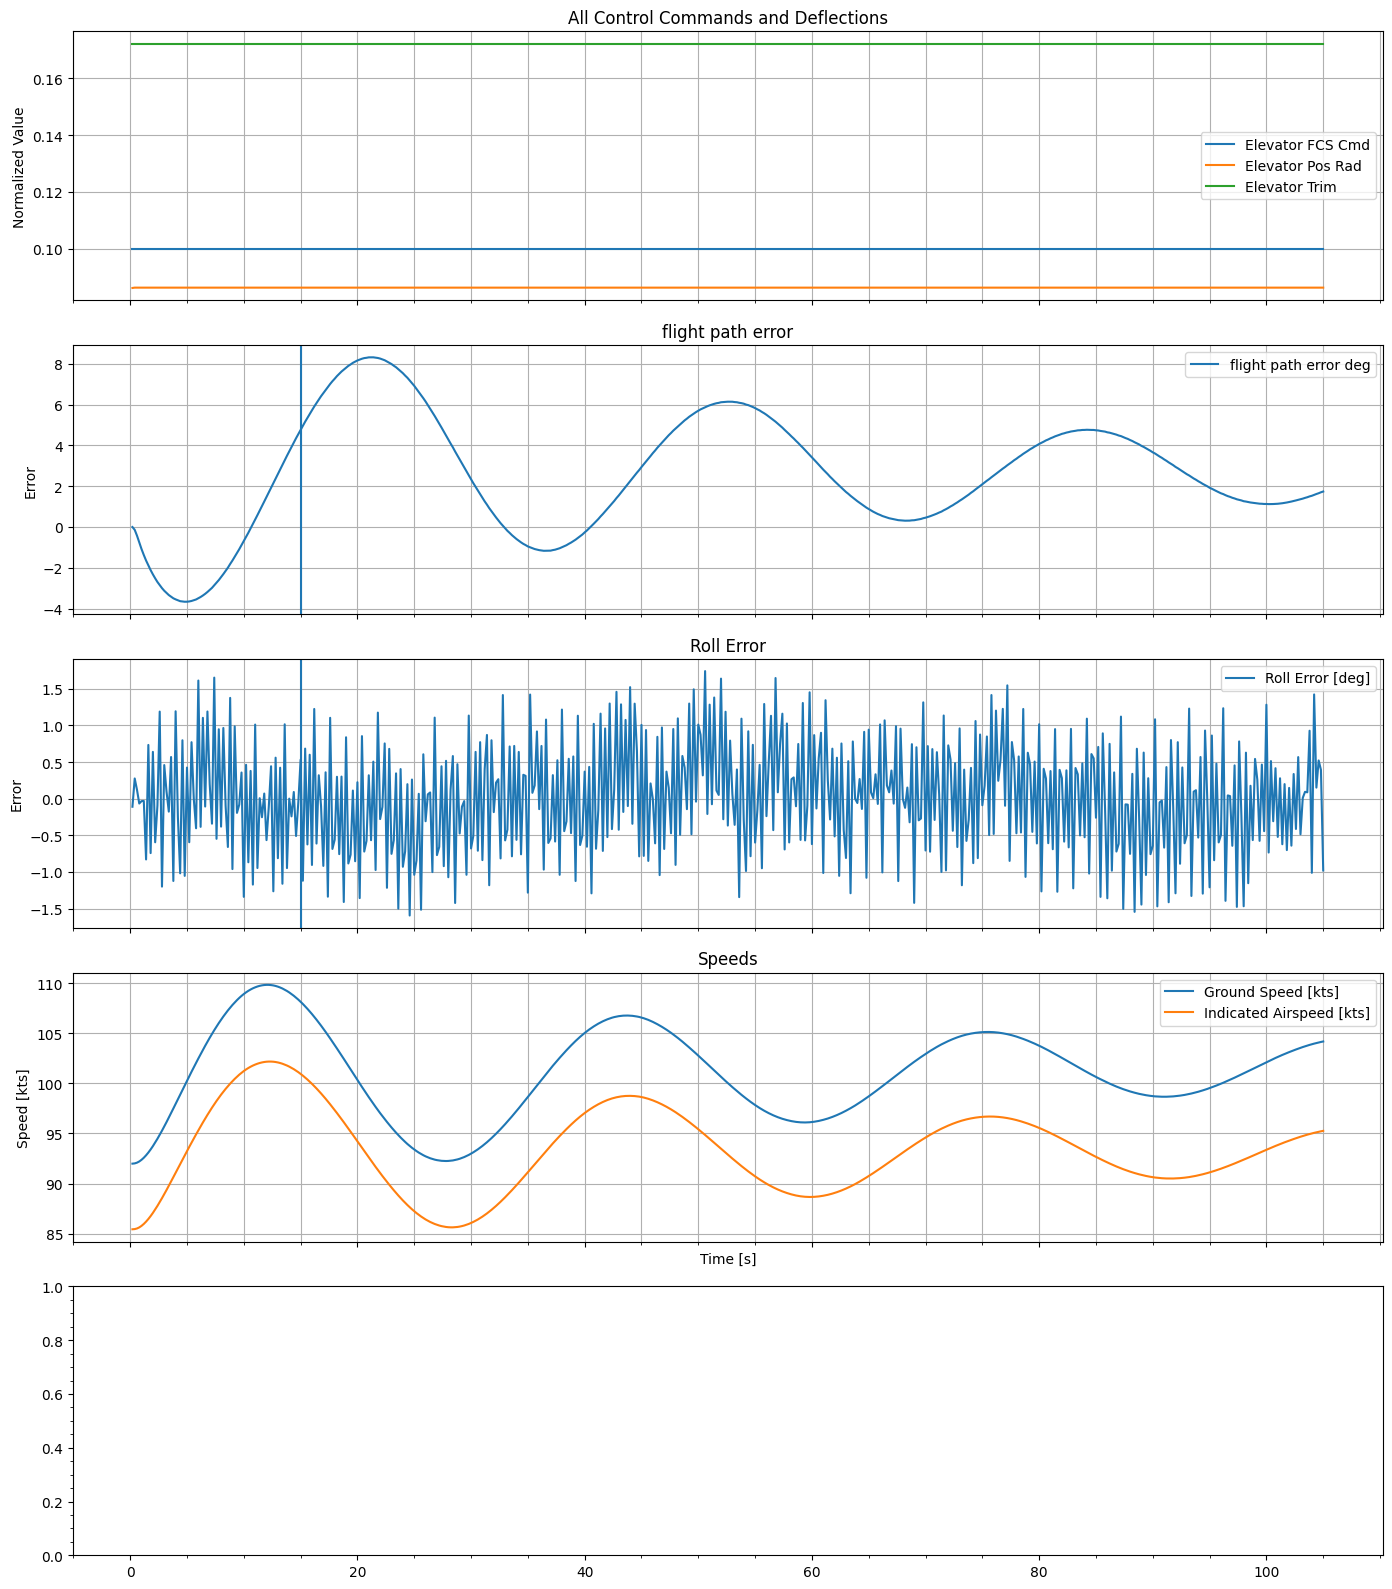

In [11]:
# testing values
control_evaluator = RPFlightControlEval(c172x)
flight_path = 1
des_airspeed = 92
des_error = 0.25
set_throttle = 1
set_elev_cmd = 0.10

control_subsystem = RPPIDControlSubsystem(pitch_subsystem=FlightPathFixedSubsystem(set_elev_cmd, set_throttle))

control_evaluator.run_specific_eval(flight_path, flight_path, 0, 0, control_subsystem, render_mode="", aircraft=c172x, start_airspeed=des_airspeed)
avg_flight_path = sum(control_evaluator.trjs_flight_path_error[-1]) / len(control_evaluator.trjs_flight_path_error[-1])
print(f"Avg flight path: {avg_flight_path}")
control_evaluator.plot_eval(-1)

In [1]:
from typing import Tuple
from copy import deepcopy


def _run_cmds(sim: SimulationInterface, elev_cmd: float, time: float = 90) -> Tuple[float, float, bool, bool, bool]:
    """This functions takes in a simulation and will deepcopy it immediately. Runs the commands and produces an output.

    :param sim: SimulationInterface
    :type sim: SimulationInterface
    :param elev_cmd: the elevator cmd. positive is down, negative is up
    :type elev_cmd: float
    :param time: The time in seconds the simulation should run for. Default is 90 seconds
    :type time: float
    :return: Returns a tuple of avg flight path in deg, avg calibrated airspeed, stall(t/f), overspeed(t/f), crash(t/f)
    :rtype: Tuple[float, float, bool, bool, bool]
    """
    sim = deepcopy(sim)
    control_subsystem = RPPIDControlSubsystem(pitch_subsystem=FlightPathFixedSubsystem(elev_cmd, set_throttle))
    num_steps = 0
    max_steps = time * sim.control_agent_interaction_freq
    flight_path_sum = 0
    cas_sum = 0
    stall = False
    overspeed = False
    crash = False
    crash_altitude = 5
    while num_steps < max_steps:
        actions = control_subsystem.action(sim, 90, 90)
        sim.step(actions)
        
        flight_path_sum += sim.get_property(prp.flight_path)
        cas_sum += sim.get_property(prp.cas_kts)
        if sim.get_property(prp.cas_kts) < sim.aircraft.Vs0:
            stall = True
        if sim.get_property(prp.cas_kts) > sim.aircraft.Vne:
            overspeed = True
        if sim.get_property(prp.altitude_agl_ft) < crash_altitude:
            crash = True

        num_steps += 1
    
    return (flight_path_sum / num_steps, cas_sum / num_steps, stall, overspeed, crash)

def trim_in_flight(sim: SimulationInterface, des_flight_path, max_guesses=10, des_err=0.5):
    """The simulation interface WILL be deepcopied in thi function for safety and encapsulation. The simulation must be 
    trimmed and initialized. It returns the elevator trim required to maintain the current flight path while leveling wings. 
    """
    sim = deepcopy(sim)
    upper_bound_elv_cmd = 0.5
    lower_bound_elv_cmd = -0.5
    set_cmd_flight_path = 1000 # arbitrary
    set_elev_cmd = 1000
    guesses = 0

    while abs(set_cmd_flight_path) > des_err and guesses < max_guesses:
        set_elev_cmd = (upper_bound_elv_cmd + lower_bound_elv_cmd) / 2
        set_cmd_flight_path, _, _, _, _ = _run_cmds(sim, set_elev_cmd)
        if set_cmd_flight_path > des_flight_path:
            lower_bound_elv_cmd = set_elev_cmd
        else:
            upper_bound_elv_cmd = set_elev_cmd
        
        guesses += 1
    
    return set_elev_cmd

NameError: name 'SimulationInterface' is not defined